## 1 - Import Packages

We'll make use of the following packages:
- `numpy` is a package for scientific computing in python.
- `deque` will be our data structure for our memory buffer.
- `namedtuple` will be used to store the experience tuples.
- The `gym` toolkit is a collection of environments that can be used to test reinforcement learning algorithms. We should note that in this notebook we are using `gym` version `0.24.0`.
- `PIL.Image` and `pyvirtualdisplay` are needed to render the Lunar Lander environment.
- We will use several modules from the `tensorflow.keras` framework for building deep learning models.
- `utils` is a module that contains helper functions for this assignment. You do not need to modify the code in this file.

Run the cell below to import all the necessary packages.

In [1]:
import time
from collections import deque, namedtuple
import random
import base64
import IPython

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import keras

import imageio
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

## 2 - Hyperparameters

Run the cell below to set the hyperparameters.

In [2]:
MEMORY_SIZE = 100_000     # size of memory buffer
MINIBATCH_SIZE = 64  # Mini-batch size.
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
TAU= 1e-3                 # Soft update parameter
E_DECAY = 0.995           # ε-decay rate for the ε-greedy policy.
E_MIN = 0.01              # Minimum ε value for the ε-greedy policy.

## 3 - The Lunar Lander Environment

In this notebook we will be using [OpenAI's Gym Library](https://www.gymlibrary.dev/). The Gym library provides a wide variety of environments for reinforcement learning. To put it simply, an environment represents a problem or task to be solved. In this notebook, we will try to solve the Lunar Lander environment using reinforcement learning.

The goal of the Lunar Lander environment is to land the lunar lander safely on the landing pad on the surface of the moon. The landing pad is designated by two flag poles and its center is at coordinates `(0,0)` but the lander is also allowed to land outside of the landing pad. The lander starts at the top center of the environment with a random initial force applied to its center of mass and has infinite fuel. The environment is considered solved if you get `200` points. 

In [3]:
env = gym.make('LunarLander-v2')

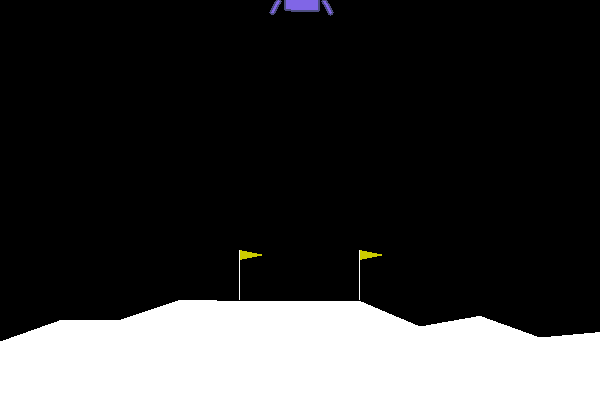

In [4]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In order to build our neural network later on we need to know the size of the state vector and the number of valid actions. We can get this information from our environment by using the `.observation_space.shape` and `action_space.n` methods, respectively.

In [5]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


Here we define the $Q$ and target $\hat Q$ networks

In [6]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'), 
    ])

optimizer = Adam(learning_rate=ALPHA)   

# Experience Replay

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as **Experience Replay** to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

In [7]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [8]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards+(1-done_vals)*max_qsa*gamma
    
    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    loss = MSE(y_targets,q_values)    
    return loss

The `agent_learn` function will update the weights of the $Q$ and target $\hat Q$ networks using a custom training loop.

In [9]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    # update the weights of target q_network
    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

Experience Relay Implementation

In [10]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)

The agent observes the current `state` and chooses an `action` using an $\epsilon$-greedy policy. Our agent starts out using a value of $\epsilon =$ `epsilon = 1` which yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy. This means that at the beginning of our training, the agent is just going to take random actions regardless of the observed `state`. As training progresses we will decrease the value of $\epsilon$ slowly towards a minimum value using a given $\epsilon$-decay rate. We want this minimum value to be close to zero because a value of $\epsilon = 0$ will yield an $\epsilon$-greedy policy that is equivalent to the greedy policy. This means that towards the end of training, the agent will lean towards selecting the `action` that it believes (based on its past experiences) will maximize $Q(s,a)$. We will set the minimum $\epsilon$ value to be `0.01` and not exactly 0 because we always want to keep a little bit of exploration during training.

In [11]:
def get_action(q_values, epsilon=0.0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        if (t + 1) % NUM_STEPS_FOR_UPDATE == 0 and len(memory_buffer) > MINIBATCH_SIZE:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = max(E_MIN, E_DECAY * epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -147.56
Episode 135 | Total point average of the last 100 episodes: -132.30

We can plot the total point history along with the moving average to see how our agent improved during training. If you want to know about the different plotting options available in the `utils.plot_history` function we encourage you to take a look at the `utils` module.

In [ ]:
q_network=keras.models.load_model('lunar_lander_model.h5')

In [ ]:
# Generate x-axis for plotting.
episode_num = [x for x in range(0, len(total_point_history))]
window_size = (len(total_point_history) * 10) // 100
# Use Pandas to calculate the rolling mean (moving average).
rolling_mean = pd.DataFrame(total_point_history).rolling(window_size).mean()

plt.figure(figsize=(10, 7), facecolor="white")
plt.plot(episode_num, total_point_history, linewidth=1, color="cyan")
plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")

text_color = "black"

ax = plt.gca()
ax.set_facecolor("black")
plt.grid()
plt.xlabel("Episode", color=text_color, fontsize=30)
plt.ylabel("Total Points", color=text_color, fontsize=30)
yNumFmt = mticker.StrMethodFormatter("{x:,}")
ax.yaxis.set_major_formatter(yNumFmt)
ax.tick_params(axis="x", colors=text_color)
ax.tick_params(axis="y", colors=text_color)
plt.show()


In [ ]:
filename = "./videos/lunar_lander.mp4"
with imageio.get_writer(filename, fps=30) as video:
    done = False
    state = env.reset()
    frame = env.render(mode="rgb_array")
    video.append_data(frame)
    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = q_network(state)
        action = np.argmax(q_values.numpy()[0])
        state, _, done, _ = env.step(action)
        frame = env.render(mode="rgb_array")
        video.append_data(frame)

In [ ]:
video = open(filename, "rb").read()
b64 = base64.b64encode(video)
tag = """
<video width="840" height="480" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4">
Your browser does not support the video tag.
</video>""".format(
    b64.decode()
)
IPython.display.HTML(tag)